# TRVAR 

- **Time-varying reduced-rank VAR with tensor factorization**

In [1]:
import numpy as np

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def update_cg(w, r, q, Aq, rold):
    alpha = rold / np.inner(q, Aq)
    w = w + alpha * q
    r = r - alpha * Aq
    rnew = np.inner(r, r)
    q = r + (rnew / rold) * q
    return w, r, q, rnew

def ell_v(Y, Z, W, G, V_transpose, X, temp2, T):
    rank, dN = V_transpose.shape
    temp = np.zeros((rank, dN))
    for t in range(d, T):
        temp3 = np.outer(X[t, :], Z[:, t - d])
        Pt = temp2 @ np.kron(X[t, :].reshape([rank, 1]), V_transpose) @ Z[:, t - d]
        temp += np.reshape(Pt, [rank, rank], order = 'F') @ temp3
    return temp

def conj_grad_v(Y, Z, W, G, V_transpose, X, T, maxiter = 5):
    rank, dN = V_transpose.shape
    temp1 = W @ G
    temp2 = temp1.T @ temp1
    v = np.reshape(V_transpose, -1, order = 'F')
    temp = np.zeros((rank, dN))
    for t in range(d, T):
        temp3 = np.outer(X[t, :], Z[:, t - d])
        Qt = temp1.T @ Y[:, t - d]
        temp += np.reshape(Qt, [rank, rank], order = 'F') @ temp3
    r = np.reshape(temp - ell_v(Y, Z, W, G, V_transpose, X, temp2, T), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (rank, dN), order = 'F')
        Aq = np.reshape(ell_v(Y, Z, W, G, Q, X, temp2, T), -1, order = 'F')
        v, r, q, rold = update_cg(v, r, q, Aq, rold)
    return np.reshape(v, (rank, dN), order = 'F')

def trvar(mat, d, rank, maxiter = 50):
    N, T = mat.shape
    Y = mat[:, d : T]
    Z = np.zeros((d * N, T - d))
    for k in range(d):
        Z[k * N : (k + 1) * N, :] = mat[:, d - (k + 1) : T - (k + 1)]
    u, _, v = np.linalg.svd(Y, full_matrices = False)
    W = u[:, : rank]
    u, _, _ = np.linalg.svd(Z, full_matrices = False)
    V = u[:, : rank]
    u, _, _ = np.linalg.svd(mat.T, full_matrices = False)
    X = u[:, : rank]
    del u
    for it in range(maxiter):
        temp1 = np.zeros((N, rank * rank))
        temp2 = np.zeros((rank * rank, rank * rank))
        for t in range(d, T):
            temp = np.kron(X[t, :].reshape([rank, 1]), V.T) @ Z[:, t - d]
            temp1 += np.outer(Y[:, t - d], temp)
            temp2 += np.outer(temp, temp)
        G = np.linalg.pinv(W) @ temp1 @ np.linalg.inv(temp2)
        W = temp1 @ G.T @ np.linalg.inv(G @ temp2 @ G.T)
        V = conj_grad_v(Y, Z, W, G, V.T, X, T).T
        temp3 = W @ G
        for t in range(d, T):
            X[t, :] = np.linalg.pinv(temp3 @ np.kron(np.eye(rank), 
                                                     (V.T @ Z[:, t - d]).reshape([rank, 1]))) @ Y[:, t - d]
    return W, G, V, X

## On Sea Surface Temperature (SST) Dataset

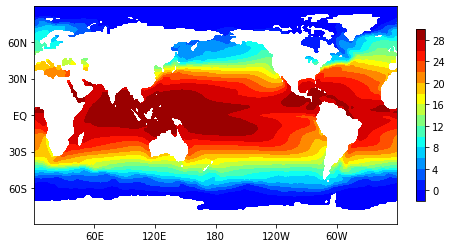

In [2]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings("ignore")

levs = np.arange(16, 29, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

fig = plt.figure(figsize = (7, 4))
mask = netcdf.NetCDFFile('datasets/SST/lsmask.nc', 'r').variables['mask'].data[0, :, :]
mask = mask.astype(float)
mask[mask == 0] = np.nan
temp = netcdf.NetCDFFile('datasets/SST/sst.wkmean.1990-present.nc', 'r').variables
plt.contourf(temp['lon'].data, temp['lat'].data, 
             np.mean(temp['sst'].data[: 1565, :, :], axis = 0) / 100 * mask, 
             levels = 20, linewidths = 1, vmin = 0, cmap = cm)
plt.xticks(np.arange(60, 350, 60), ['60E', '120E', '180', '120W', '60W'])
plt.yticks(np.arange(-60, 90, 30), ['60S', '30S', 'EQ', '30N', '60N'])
cbar = plt.colorbar(fraction = 0.022)
plt.show()
fig.savefig("graphics/mean_temperature.pdf", bbox_inches = "tight")

In [4]:
import numpy as np
from scipy.io import netcdf
import time

data = netcdf.NetCDFFile('datasets/SST/sst.wkmean.1990-present.nc', 'r').variables
tensor = data['sst'].data[:, :, :] / 100
T, M, N = tensor.shape
mat = np.zeros((M * N, T))
for t in range(T):
    mat[:, t] = tensor[t, :, :].reshape([M * N])

for rank in [6]:
    for d in [1]:
        start = time.time()
        W, G, V, X = trvar(mat, d, rank)
        print('rank R = {}'.format(rank))
        print('Order d = {}'.format(d))
        end = time.time()
        print('Running time: %d seconds'%(end - start))

rank R = 6
Order d = 1
Running time: 15546 seconds


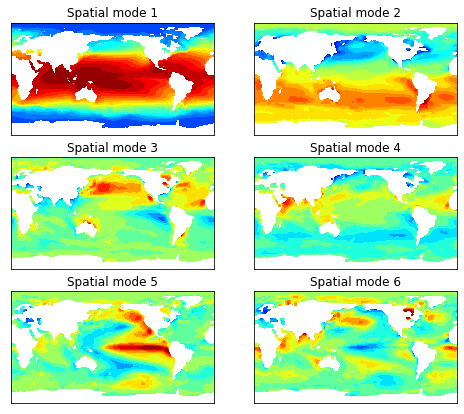

In [40]:
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

levs = np.arange(16, 29, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

mask = netcdf.NetCDFFile('datasets/SST/lsmask.nc', 'r').variables['mask'].data[0, :, :]
mask = mask.astype(float)
mask[mask == 0] = np.nan

fig = plt.figure(figsize = (8, 7))
for t in range(6):
    ax = fig.add_subplot(3, 2, t + 1)
    if t + 1 == 1:
        vmin = -0.001
        vmax = 0.007
        plt.contourf(data['lon'].data, data['lat'].data,
                     W[:, t].reshape((M, N)) * mask, levels = np.linspace(vmin, vmax, 20), 
                     linewidths = 1, cmap = cm)
    elif t + 1 == 6 or t + 1 == 3 or t + 1 == 4 or t + 1 == 5:
        vmin = -0.015
        vmax = 0.02
        plt.contourf(data['lon'].data, data['lat'].data,
                     W[:, t].reshape((M, N)) * mask, levels = np.linspace(vmin, vmax, 15), 
                     linewidths = 1, cmap = cm)
#                      W[:, t].reshape((M, N)) * mask, levels = 20, linewidths = 1, 
#                      vmin = -0.015, vmax = 0.015, cmap = cm)
    elif t + 1 == 2:
        vmin = -0.01
        vmax = 0.01
        plt.contourf(data['lon'].data, data['lat'].data,
                     W[:, t].reshape((M, N)) * mask, levels = np.linspace(vmin, vmax, 20), 
                     linewidths = 1, cmap = cm)
#                      W[:, t].reshape((M, N)) * mask, levels = 20, linewidths = 1, 
#                      vmin = -0.02, vmax = 0.02, cmap = cm)
    plt.xticks([])
    plt.yticks([])
#     cbar = plt.colorbar(fraction = 0.1)
    plt.title('Spatial mode {}'.format(t + 1))
    for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.show()
fig.savefig("graphics/temperature_mode_trvar.pdf", bbox_inches = "tight")

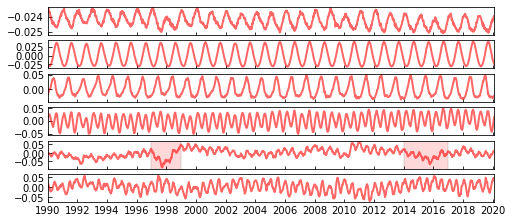

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure(figsize = (8, 0.6 * rank))
for t in range(rank):
    ax = fig.add_subplot(rank, 1, t + 1)
    plt.plot(X[:, t], linewidth = 2, alpha = 0.6, color = 'red')
    plt.xlim([1, 1565 + 1])
    plt.xticks(np.arange(1, 1565 + 1, 52))
    plt.xticks(np.arange(1, 1565 + 1, 52 * 2), np.arange(1990, 2020 + 1, 2))
    if t + 1 < rank:
        ax.tick_params(labelbottom = False)
    ax.tick_params(direction = "in")
    if t + 1 == 5:
        rect = patches.Rectangle((52 * 7, -1), 52 * 2, 2, linewidth = 2, 
                                 edgecolor = 'gray', facecolor = 'red', alpha = 0.15)
        ax.add_patch(rect)
        rect = patches.Rectangle((52 * 24 + 1, -1), 52 * 3, 2, linewidth = 2, 
                                 edgecolor = 'gray', facecolor = 'red', alpha = 0.15)
        ax.add_patch(rect)
plt.show()
fig.savefig("graphics/temperature_temporal_mode.pdf", bbox_inches = "tight")